## Loading state sentiment scores

In [2]:
import json
stateScores= json.load(open('game2_q1aShortSent2.txt'))

Now we'll import the state coordinates in Bokeh and see if we can scatter these '

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib nbagg

<IPython.core.display.Javascript object>


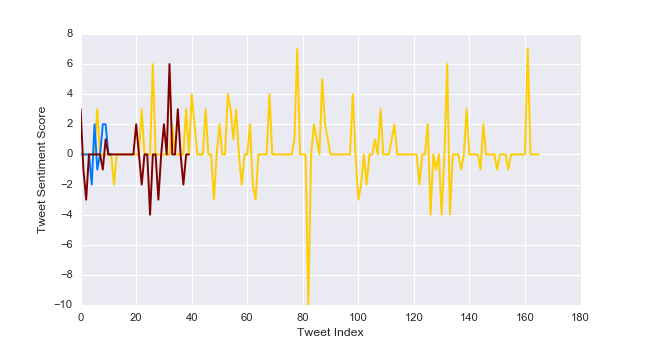

In [7]:
plt.plot(range(0,len(stateScores['CA'])), stateScores['CA'], color = '#FFCD00')
plt.plot(range(0,len(stateScores['OK'])), stateScores['OK'], color= '#0077FF')
plt.plot(range(0,len(stateScores['OH'])), stateScores['OH'], color= 'maroon')
plt.xlabel('Tweet Index')
plt.ylabel('Tweet Sentiment Score')

In [183]:
#Load raw data into dataframe
df= pd.DataFrame.from_dict(stateScores, orient= 'index')

In [214]:
df2= df.transpose()
df2.head(3)

,WA,DE,DC,WI,WV,HI,FL,WY,NH,NJ,...,MN,MI,KS,MT,MP,MS,SC,KY,OR,SD
0,0,0,-1,0,2,-1,-1,NaN,0,8,...,1,0,0,5,NaN,0,0,0,1,0
1,2,NaN,0,0,-3,1,-2,NaN,NaN,-8,...,2,0,0,NaN,NaN,0,-1,0,0,NaN
2,0,NaN,1,4,-1,NaN,0,NaN,NaN,2,...,0,-1,-4,NaN,NaN,0,5,0,0,NaN


In order to visualize the data on a map easily, we'll drop the non-continental states and territories. First we'll drop them from the map coordinates from bokeh, and then from the dataframe df2.

In [301]:
#First delete/exclude from the bokeh coordinate dictionary and sort them alphabetically
from bokeh.plotting import figure, show, output_file
from bokeh.sampledata.us_states import data as states

# del states["HI"]
# del states["AK"]

EXCLUDED = ("ak", "hi", "pr", "gu", "vi", "mp", "as")#Exclude territories

import collections#This will allow us to order our states to match coordinates of coord library with data

ordStates= collections.OrderedDict(sorted(states.items()))

In [308]:
#Now exclude Hawaii, Alaska, and territories from our dataframe
df3= df2.drop(['HI','AK','PR','GU','VI','MP','AS','NA'], axis= 1)#For some reason we also have a 'NA' column, drop that too

Now we'll count the number of tweets in in each state in df3 and calculate the mean tweet score for all the columns/states/series (will ignore NaN's, but output is NaN if the list for a state was empty). 

In [309]:
dfCount= df3.count()
dfMean= df3.mean()
#zip(dfCount, dfMean)

So now we have three dataframes: df3 = filtered data, dfCount = tweet count for each state in df3, dfMean= mean tweet score for each state in df3.  We'll use these to build our map and <strong>scale and normalize our tweet sentiment score data</strong>.
Since some of our values are negative, we'll account for that as well.

In [310]:
#First I'll convert this to a dictionary to play with just the values and order the dictionary to match ordStates
dfMeanDict= dfMean.to_dict()
ordMeanDict= collections.OrderedDict(sorted(dfMeanDict.items()))

#I'll also turn the item values into lists to make it easy to normalize scores
ordScoreKey= ordMeanDict.keys()
ordMeanScore= ordMeanDict.values()

#Now we'll calculate the min scores to help us normalize the data
minScore= min(ordMeanScore)

In [311]:
normScores= ordMeanScore+abs(minScore)#Shifts baseline scores by absolute value of minimum score 
normScores= normScores/max(normScores)#Normalize scores to range of 0 to 1

In [467]:
#Get weight after converting count dictionary and sorting based on key, then taking values like we did with scores
weights= dfCount.to_dict()#Convert to dict
orderedCounts= collections.OrderedDict(sorted(weights.items())).values()#Sort dict by key, take values list
weights= np.float64(orderedCounts)/max(orderedCounts)#Normalize weight by max value

In [320]:
#Let's check if our dictionaries match
#zip(ordScoreKey,ordStates.keys())

Great. Now we have a sorted dictionary for our state coordinates (ordStates), a list of normalized tweetscores whose values match the order of the dictionary (normScores), and a list of corresponding weights for said scores (weights). We can now visualize the data! 

In [384]:
#Here, we'll split the coordinates of all the states into x,y lists and initialize our figure object
state_xs = [ordStates[code]["lons"] for code in ordStates]
state_ys = [ordStates[code]["lats"] for code in ordStates]

Now we'll generate a list of colors that we'll use to represent tweet score values. We'll use the cmap object to return a RGBA value depending on what value from 0 to 1 we feed it from our normalized tweet score list. 

In [473]:
import matplotlib
cmap= matplotlib.cm.get_cmap('bwr')#Initialize cmap object

In [474]:
colorScore= []#Initialize list
for i in range(0,len(normScores)):
    if np.isnan(normScores[i]):#If the normScores value is nan (no tweets), return white (not in 'viridis' colormap)
        colorScore.append('#000000')
        
    else:
        colorScore.append(matplotlib.colors.rgb2hex(cmap(normScores[i])[:3]))
# print 'Score, Viridis hex value'
# zip(normScores,colorScore)

Not all the states have the same number of tweets, thus we'll need to represent this in our map. The alpha transparency property will be a good way to scale the color intensity of each state based on the weights we calculated for each state. The more transparent the color, the fewer tweets it generated.

In [475]:
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool

#We'll now make the source for the info on our hover
source= ColumnDataSource(data= dict(stateKey=ordScoreKey, counts=orderedCounts, score=ordMeanScore))

hover= HoverTool(tooltips= [("State", "@stateKey"), ("Avg Tweet Score", "@score"), ("# of Tweets", "@counts")])

p = figure(title="Twitter Sentiment Scores full bwr ", tools=[hover, 'wheel_zoom', 'pan', 'reset'], toolbar_location="left",
           plot_width=1100, plot_height=700)

#Plot map and use color list to assign colors
p.patches(state_xs, state_ys, line_color= 'black', color= colorScore, source= source)#, fill_alpha= alphaWeights)
#This part here is the tricky part ,we must take the order listed by states and match it with our score/weight order

output_file("choropleth.html", title="choropleth.py example")
show(p)

In [382]:
#plt.hist(np.log(weights))
np.log(weights)

array([-2.27877444, -4.0133755 , -1.97649357,  0.        , -2.62708114,
       -2.54703843, -1.89311196, -5.11198779, -0.66933653, -0.82152835,
       -3.50254988, -3.72569343, -1.26184019, -2.47293046, -2.91476321,
       -2.62708114, -2.11625551, -2.33939907, -1.97649357, -4.0133755 ,
       -1.52846885, -2.22161603, -2.27877444, -3.50254988, -5.11198779,
       -1.24078678, -5.11198779, -3.03254625, -5.11198779, -1.77978328,
       -4.41884061, -2.71409252, -0.43915895, -1.42310833, -2.62708114,
       -3.16607764, -1.74469196, -4.41884061, -2.40393759, -5.11198779,
       -1.81615092, -0.06213178, -3.72569343, -1.71079041,        -inf,
       -1.58562726, -3.16607764, -4.0133755 ,        -inf])

### The following will be additional analysis for the scatterplots for just a few teams/states

In [ ]:
df3= df2[['CA','OK','VA','DC','OH']]
df3.tail(3)
sns.violinplot(df3)#This works but sns.swarmplot doesn't says index 166 out of bounds?
sns.boxplot(df3)#Look here: http://web.stanford.edu/~mwaskom/software/seaborn/generated/seaborn.swarmplot.html 
plt.ylabel('Tweet Sentiment Score')

### Extra blocks of code I deleted

In [317]:
# #Here I will filter out the states with NaN
# state_colors= []
# for st8 in states:
#     if st8 in EXCLUDED:
#         continue
#     try:
#         score= df6[st8]
#         state_colors.append(score)
#     except KeyError:
#         state_colors.append(np.NaN)

In [318]:
#Saving this cell in case, updating the nan values does matter (they should already be in there)

# #With this list I'm making all state avgs positive
# #Then I'm normalizing to 1 the resulting list st8ColNorm by its max value
# st8ColNorm= state_colors+abs(minVal)#Normalize to positive val
# print min(st8ColNorm), max(st8ColNorm)
# st8ColNorm1= st8ColNorm/max(st8ColNorm)#Normalize to 1
# st8ColNorm1[np.isnan(st8ColNorm1)] = np.nan
# print 'Type is: ', st8ColNorm1[6]
# print type(st8ColNorm1[6])
# st8ColNorm1